### Saliency maps using ResNet-50 in tensorflow

Implementation of "Interpretable Explanations of Black Boxes by Meaningful Perturbation" ( https://arxiv.org/abs/1704.03296 )

In [1]:
import tensorflow as tf
import numpy as np
import cv2

In [2]:
from matplotlib import pyplot as pl
%matplotlib inline

In [107]:
tv_beta = 3
learning_rate = 0.1
max_iterations = 500
l1_coeff = 0.05
tv_coeff = 0.2
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

from keras.utils.data_utils import get_file
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                WEIGHTS_PATH,
                                cache_subdir='models',
                                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')

In [59]:
img_name = 'flute.jpg'
original_img = cv2.imread(img_name, 1)
original_img = cv2.resize(original_img, (224, 224))

img = np.float32(original_img) 
blurred_img1 = cv2.GaussianBlur(img, (11, 11), 11)
blurred_img2 = np.float32(cv2.medianBlur(original_img, 11))
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
mask_init = np.ones((28, 28), dtype = np.float32)

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [9]:
# only for model testing, not needed
model=ResNet50(weights='imagenet')

x = image.img_to_array(img.copy())
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

-117.68 151.061
Predicted: [('n03372029', 'flute', 0.99989641), ('n03838899', 'oboe', 3.7382819e-05), ('n04376876', 'syringe', 3.4892237e-05)]


In [74]:
def tv_norm(input, tv_beta):
  img = input[:,:,0]
  print(img.shape)
  row_grad = tf.reduce_mean(tf.pow(tf.abs((img[:-1 , :] - img[1 :, :])),tv_beta))
  col_grad = tf.reduce_mean(tf.pow(tf.abs((img[: , :-1] - img[: , 1 :])),tv_beta))
  return row_grad + col_grad

In [108]:
from keras import backend as K
K.set_learning_phase(0)

inp_img = image.img_to_array(img.copy())
inp_img = np.expand_dims(inp_img, axis=0)
inp_img = preprocess_input(inp_img)
input_img = tf.constant(inp_img)#(inp_img / 255. - 0.5) * 2.)

#target = model.predict(inp_img)
category = 558#np.argmax(target)
#print("Category with highest probability:", category, target[0,category])
print("Optimizing.. ")

blurred_img = image.img_to_array(blurred_img_numpy.copy())
blurred_img = np.expand_dims(blurred_img, axis=0)
blurred_img = preprocess_input(blurred_img)
blurred_img = tf.constant(blurred_img)

mask_v = tf.Variable(mask_init)
clipped_mask = tf.clip_by_value(mask_v, 0.0, 1.0)
mask_r = tf.reshape(mask_v,[28,28,1])
upsample = tf.image.resize_images(mask_r,(224,224))

print(upsample.shape)
upsampled_mask = tf.tile(upsample, [1,1,3])
print(upsampled_mask.shape)

perturbated_input = input_img * upsampled_mask + blurred_img * (1-upsampled_mask)

noise = tf.random_normal([224,224,3],mean=0.0, stddev=2)
perturbated_input += noise

base_model = ResNet50(weights='imagenet', input_tensor=perturbated_input)
outputs = base_model.outputs[0]

tv_loss = tv_coeff*tv_norm(mask_r, tv_beta)
l1_loss = l1_coeff*tf.reduce_mean(tf.abs(1 - mask_v)) 
loss = l1_loss + tv_loss + outputs[0, category]

optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss, var_list=[mask_v])


Optimizing.. 
(224, 224, 1)
(224, 224, 3)
(28, 28)


In [109]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

base_model.load_weights(weights_path)

for step in range(1):##max_iterations):
  op,i = sess.run([outputs,input_img])
  print(decode_predictions(op, top=3)[0])
  print(op[0,558])  

[('n03372029', 'flute', 0.9999162), ('n03838899', 'oboe', 3.2830998e-05), ('n04376876', 'syringe', 2.7684118e-05)]
0.999916


In [110]:
for step in range(max_iterations):
  _, loss_, op,m,cm,res_mask, tvl, l1_loss_ = \
  sess.run([train_op, loss,outputs,mask_v,clipped_mask, upsample, tv_loss, l1_loss])
  print(loss_,tvl, l1_loss_, op[0,558],np.sum(m), np.sum(cm), np.max(m), np.min(m))
  if step % 20000 == -1:
    assign_op = mask_v.assign(cm)
    sess.run(assign_op)


0.999828 0.0 0.0 0.999828 784.0 784.0 1.0 1.0
1.00152 0.000618833 0.00337496 0.997525 779.748 755.414 1.09969 0.90019
0.98212 0.00109685 0.00285097 0.978172 786.74 763.018 1.19463 0.805158
0.916902 0.00266667 0.00441752 0.909817 788.305 751.519 1.26843 0.722435
0.408067 0.00577959 0.00574856 0.396539 786.671 740.267 1.33307 0.659743
0.120716 0.0111177 0.00763176 0.101967 779.812 722.073 1.4192 0.592039
0.0501665 0.0191222 0.00960259 0.0214418 772.716 703.074 1.49973 0.519365
0.0450031 0.0287049 0.0112268 0.00507142 766.407 687.185 1.58094 0.451859
0.0538294 0.0385353 0.0124698 0.00282431 761.617 675.045 1.6488 0.388299
0.0623442 0.0476035 0.0133783 0.00136248 758.069 666.149 1.70963 0.329374
0.0704109 0.0552929 0.0140585 0.00105953 755.647 659.605 1.76419 0.276561
0.0763071 0.0613101 0.0145326 0.00046452 753.867 654.998 1.8117 0.229579
0.0807815 0.0655975 0.0148184 0.00036557 752.622 652.134 1.85306 0.188025
0.0835006 0.0682551 0.0149426 0.000302884 751.835 650.767 1.88879 0.151404
0.0

0.00830473 0.00332979 0.00427778 0.000697164 768.465 742.695 2.04634 0.00657918
0.00833769 0.00331184 0.00426689 0.00075896 768.396 742.746 2.04767 0.00693647
0.00845742 0.00329312 0.00426476 0.000899541 768.382 742.755 2.04893 0.00749964
0.00817371 0.00327759 0.00425275 0.000643376 768.326 742.821 2.05077 0.00740953
0.00832905 0.0032592 0.00422388 0.000845968 768.043 742.906 2.05233 0.00754085
0.00811339 0.00324222 0.0041938 0.000677367 767.674 742.958 2.05401 0.00772422
0.00815159 0.00322365 0.00419331 0.000734632 767.399 742.824 2.05504 0.00875132
0.00837895 0.00320351 0.00419744 0.000978005 767.208 742.696 2.05551 0.0105994
0.00818566 0.00318469 0.00418026 0.000820719 766.781 742.617 2.05583 0.0106434
0.00779328 0.00316513 0.0041445 0.000483652 766.496 742.755 2.05602 0.0104781
0.00793167 0.00313967 0.004137 0.000655002 766.438 742.785 2.05551 0.0107092
0.00805986 0.00311288 0.00412864 0.000818345 766.588 742.926 2.055 0.0115801
0.00792992 0.00308977 0.0041249 0.000715246 766.679 7

0.00663575 0.00243289 0.0036395 0.000563362 755.2 741.124 1.98137 -0.0447319
0.00674326 0.00240035 0.00363302 0.000709895 755.279 741.209 1.97707 -0.0445211
0.00674742 0.00236897 0.00361882 0.000759636 755.462 741.407 1.97235 -0.0443037
0.00708583 0.00234139 0.00359451 0.00114993 755.618 741.672 1.96797 -0.044035
0.00662207 0.00232335 0.00357923 0.000719479 755.595 741.781 1.96478 -0.0440877
0.00685034 0.00230729 0.00359108 0.000951968 755.491 741.635 1.9619 -0.0437286
0.00657313 0.00229799 0.00359328 0.00068186 755.446 741.595 1.95952 -0.0433956
0.00664098 0.00228908 0.00357832 0.000773581 755.315 741.647 1.95703 -0.0432424
0.00674392 0.00228216 0.00355771 0.000904046 755.286 741.794 1.9549 -0.0431327
0.00659955 0.00227914 0.00355561 0.000764793 755.262 741.798 1.95317 -0.0432239
0.00666532 0.00227625 0.00356022 0.000828854 755.429 741.846 1.95156 -0.0438572
0.00663992 0.0022773 0.00357628 0.00078634 755.295 741.654 1.95032 -0.0447171
0.00660032 0.00227694 0.00357572 0.000747659 754.9

0.00509648 0.0014762 0.00324094 0.000379341 748.267 740.94 1.34122 -0.0792312
0.00495233 0.0014752 0.0032358 0.000241338 748.164 740.929 1.34173 -0.0787068
0.00484304 0.00146893 0.00323555 0.000138559 748.076 740.885 1.34033 -0.0779026
0.00519874 0.00145596 0.00324046 0.000502324 747.889 740.749 1.33608 -0.076853
0.005053 0.00144562 0.00323308 0.000374294 747.808 740.763 1.33287 -0.0756947
0.00522633 0.00143425 0.00321293 0.000579157 747.844 740.936 1.33138 -0.0745035
0.00480115 0.00142322 0.00320009 0.000177836 747.934 741.081 1.33005 -0.0733674
0.00496982 0.00140698 0.00320331 0.000359534 748.155 741.162 1.32848 -0.0720572
0.00491553 0.00139201 0.00321075 0.000312769 748.279 741.164 1.32683 -0.0705699
0.00476435 0.00137629 0.00319568 0.000192377 748.31 741.295 1.32518 -0.0695703
0.00473965 0.00135788 0.00317043 0.000211343 748.049 741.358 1.32324 -0.0685315
0.00491571 0.00133968 0.00316532 0.00041071 747.603 741.171 1.32118 -0.0676088
0.00493318 0.00132587 0.00316417 0.000443141 747.

0.0048505 0.00124835 0.00306904 0.000533105 746.891 741.647 1.26415 -0.122834
0.00474493 0.00122988 0.00306357 0.00045148 746.71 741.586 1.2629 -0.121854
0.00477362 0.00121705 0.00304584 0.00051073 746.667 741.696 1.26246 -0.120954
0.00468574 0.00120954 0.00305136 0.000424846 746.821 741.732 1.26274 -0.120824
0.00481457 0.00120638 0.0030531 0.000555094 746.939 741.784 1.26285 -0.120445
0.00468936 0.001209 0.00305413 0.000426237 746.854 741.746 1.26384 -0.120675
0.00477304 0.00121236 0.00305214 0.000508544 746.559 741.627 1.26509 -0.120804
0.00454827 0.00121819 0.00306573 0.00026435 746.387 741.446 1.26658 -0.120825
0.00466496 0.00122236 0.00306005 0.000382543 746.449 741.531 1.26735 -0.120511
0.00459593 0.00122285 0.00306185 0.000311225 746.411 741.504 1.26748 -0.120062
0.00455944 0.00122139 0.00305333 0.000284728 746.445 741.592 1.26685 -0.119362
0.00458225 0.00121667 0.00303874 0.000326838 746.65 741.808 1.26615 -0.118405
0.00456918 0.00121079 0.00303638 0.000322008 746.792 741.894 1

In [111]:
print(np.sum(np.abs(1-m)))

48.0193


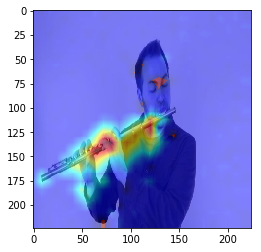

In [140]:
# visualize results

mask = res_mask.copy()
mask = (mask - np.min(mask)) / np.max(mask)

heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)

heatmap = np.float32(heatmap)
cam = 1.0*heatmap + np.float32(img)
cam = cam / np.max(cam)

perturbated = np.multiply(mask, img) + np.multiply(1-mask, blurred_img_numpy) 

pl.imshow(np.array(cam*255,np.uint8))

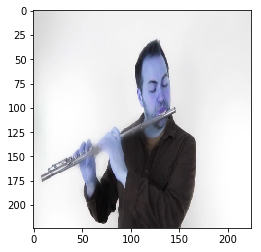

In [141]:
pl.imshow(np.array(perturbated,np.uint8))